In [29]:
import pandas as pd
import numpy as np
import time

import scanpy as sc
from anndata.experimental.pytorch import AnnLoader

import pretty_confusion_matrix as pcm

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchnet.meter import ClassErrorMeter, AverageValueMeter
# from torch_prototypes.modules import prototypical_network
import prototypical_network
from torch_prototypes.metrics import distortion, cost
from torch_prototypes.metrics.distortion import DistortionLoss
from  torch.distributions import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

import helper_fns
import preprocess as pp
from anndata import AnnData
import vanilla_vae
from sklearn.decomposition import TruncatedSVD

In [37]:
# --------------Parameters-------------------
embedding_dim = 2
hidden_dim = 512
k_fold = 5
cross_validation = False
num_epoch=30
batch_size=512
feature_selection = True
num_genes = 36601
# --------------Plotting---------------------
plot_loss = True
plot_embedding_space = True
plot_confusion_matrix = True

dataset = sc.read_h5ad("C:/Users/xbh04/Desktop/b-cells.h5ad")
dataset_Pro_B = dataset[dataset.obs['Manually_curated_celltype'] == 'Pro-B']
dataset = dataset[dataset.obs['Manually_curated_celltype'] != 'MNP/B doublets']
dataset = dataset[dataset.obs['Manually_curated_celltype'] != 'T/B doublets']
dataset = dataset[dataset.obs['Manually_curated_celltype'] != 'ABCs']
dataset = dataset[dataset.obs['Manually_curated_celltype'] != 'Pro-B']
pca = TruncatedSVD(n_components=100)
pca.fit(dataset.X)
dataset_pca = AnnData(pca.transform(dataset.X))
dataset_pca.obs = dataset.obs
encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset.obs['Manually_curated_celltype'])
encoders = {
    'obs': {
        'Manually_curated_celltype': encoder_celltype.transform
    }
}
train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset_pca, cross_validation=cross_validation, k_fold=k_fold)

In [25]:
def train_nn(l_metric=2, l_pl = 2, epochs = num_epoch, D_metric=None, D_cost=None, cuda=1):
    # D_metric = D_metric.cuda()
    model = vanilla_vae.VanillaVAE(100, 2, [128, 64, 32]).cuda()
    dl_train = dataloader_training
    

    opt = torch.optim.Adam(model.parameters())

    if plot_embedding_space:
        training_embeddings = []
        training_labels = []
        testing_embeddings = []
        testing_true_labels = []
    for epoch in range(1, epochs+1):
        print('Epoch {}'.format(epoch))

        model.train()
        t0 = time.time()
        overall_loss = 0
        for batch in dl_train:
            x = batch.X.cuda()
            y = batch.obs['Cell_Type']
            x_hat,x, mean, log_var= model(x)
            opt.zero_grad()
            # reconst_loss = F.mse_loss(x_hat, x)
            # kl_div = -0.5 * torch.sum(1 + log_var - mean**2 - log_var.exp())
            
            vae_loss = model.loss_function(x_hat, x, mean, log_var, M_N=1)
            if epoch == epochs and plot_embedding_space:
                training_labels.extend(y)
            loss = vae_loss['loss']
            overall_loss+=loss
            loss.backward()
            opt.step()

        print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / 512)

        t1 = time.time()

        results = {}
        results['model'] = model
        if plot_embedding_space:
            results['training_labels'] = training_labels
    return results

In [26]:
kfold = KFold(n_splits=k_fold, shuffle=True)
# Start print
print('--------------------------------')
model_list = []

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
      # Print
      print(f'FOLD {fold}')
      print('--------------------------------')

      # Sample elements randomly from a given list of ids, no replacement.
      train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
      test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
      if feature_selection:
            train_dataset = dataset[train_indices]
            dataset = pp.regularPreprocess(dataset)
            sc.pp.pca(dataset, n_comps=100)
            pca = AnnData(dataset.obsm['X_pca'])
            pca.obs['Cell_Type'] = np.array(dataset.obs['Manually_curated_celltype'])
            # test_dataset = 
            # train_dataset = helper_fns.select_features(train_dataset)
            # dataset = dataset[:,train_dataset.var_names]
            # num_genes = len(train_dataset.var_names)
      # Define data loaders for training and testing data in this fold
            
      # sc.pp.normalize_total(dataset, target_sum = 1e4)
      # sc.pp.log1p(dataset)
      dataloader_training = AnnLoader(pca, batch_size=batch_size, convert=encoders, sampler=train_subsampler)
      # dataloader_testing = AnnLoader(dataset, batch_size=batch_size, convert=encoders, sampler=test_subsampler)
      num_genes=100
      results = train_nn(l_metric=1)
      model_list.append(results)
      
      if not cross_validation:
            break

--------------------------------
FOLD 0
--------------------------------


c:\Users\xbh04\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


NameError: name 'D' is not defined

In [27]:
results = train_nn(l_metric=1)

Epoch 1
	Epoch 2 complete! 	Average Loss:  tensor(0.7063, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 2
	Epoch 3 complete! 	Average Loss:  tensor(0.7056, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 3
	Epoch 4 complete! 	Average Loss:  tensor(0.7057, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 4
	Epoch 5 complete! 	Average Loss:  tensor(0.7056, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 5
	Epoch 6 complete! 	Average Loss:  tensor(0.6874, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 6
	Epoch 7 complete! 	Average Loss:  tensor(0.6603, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 7
	Epoch 8 complete! 	Average Loss:  tensor(0.6577, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 8
	Epoch 9 complete! 	Average Loss:  tensor(0.6574, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 9
	Epoch 10 complete! 	Average Loss:  tensor(0.6571, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 10
	Epoch 11 complete! 	Average Loss:  tensor(0.6574, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 1

GC_B (I)
GC_B (II)
Memory B cells
Naive B cells
Plasma cells
Plasmablasts
Pre-B


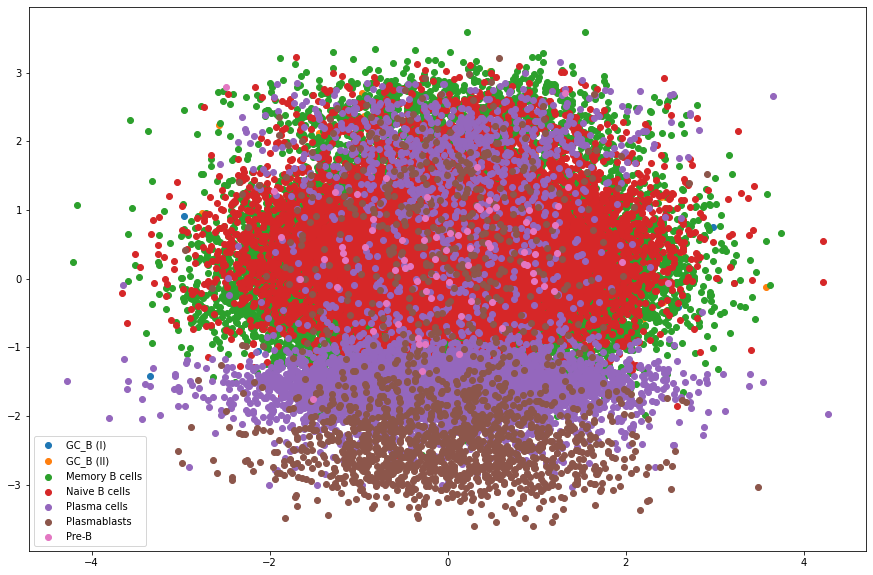

In [28]:
encoded = results.get('model').encode(torch.Tensor(pca.X).cuda())
a = []
for i in range(len(encoded[0])):
    a.append(results.get('model').reparameterize(encoded[0][i], encoded[1][i]))

encoded_mean_np = []
for i in range(len(encoded[0])):
    encoded_mean_np.append(np.array(a[i].detach().cpu()))
fig, ax = plt.subplots(figsize=(15, 10))
# for color in ["Memory B cells", "Naive B cells"]:
for color in np.unique(np.array(pca.obs['Cell_Type'])):
# for color in ["Memory B cells", "Naive B cells"]:
    print(color)
    i = np.where(pca.obs['Cell_Type'] == color)
    ax.scatter(np.array(encoded_mean_np)[i,0], np.array(encoded_mean_np)[i,1], label=color)
ax.legend()
plt.show()

In [ ]:
# Training
training_embeddings = results.get('model').encode(torch.Tensor(pca.X).cuda())
training_embeddings_labels = results.get('training_labels')
for i in range(len(training_embeddings_labels)):
    if type(training_embeddings[i]) != np.ndarray:
        training_embeddings[i] = training_embeddings[i].detach().cpu().numpy()
if plot_embedding_space:
    fig, ax = plt.subplots(figsize=(15, 10))
    for color in np.unique(np.array(training_embeddings_labels)):
    # for color in ["Memory B cells", "Naive B cells"]:
        print(color)
        i = np.where(np.array(training_embeddings_labels) == color)
        print(i)
        ax.scatter(np.array(training_embeddings)[i,0], np.array(training_embeddings)[i,1], label=color)
    ax.legend()
    plt.show()

IndexError: list index out of range